In [19]:
##############################################
# Import Library
##############################################

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.isotonic import IsotonicRegression
from sklearn.model_selection import train_test_split

from imblearn.datasets import fetch_datasets

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
from scipy.stats import bernoulli, zscore

import calibration_metric
import importlib
importlib.reload(calibration_metric)
from calibration_metric import ece, ace, tce

In [20]:
##############################################
# Prepare Algorithms
##############################################

def pick_algorithm(name_alg):
    if name_alg == "LR":
        return LogisticRegression(max_iter=10000, random_state=0)
    elif name_alg == "SVM":
        return SVC(kernel='rbf', probability=True, random_state=0)
    elif name_alg == "RF":
        return RandomForestClassifier(max_depth=10, random_state=0)
    elif name_alg == "GB":
        return GradientBoostingClassifier(random_state=0)
    elif name_alg == "MLP":
        return MLPClassifier(hidden_layer_sizes=(1000), max_iter=10000, random_state=0)
    else:
        assert False, "No Algorithm"

names_alg = ['LR', 'SVM', 'RF', 'GB', 'MLP']


In [21]:
##############################################
# Prepare Data
##############################################

# Utility Function
def process(df, test_size=0.3):
    df_X = df.data
    df_y = df.target.astype(int)
    m = df_X.mean(axis=0)
    s = df_X.std(axis=0)
    s[s==0] = 1
    df_X = ( df_X - m ) / s
    df_y[df_y == -1] = 0
    df_train_X, df_test_X = train_test_split(df_X, test_size=test_size, random_state=0)
    df_train_y, df_test_y = train_test_split(df_y, test_size=test_size, random_state=0)
    return (df_train_X, df_train_y, df_test_X, df_test_y)


def process_11(df, y_column, pos_index=1, test_size=0.3):
    if isinstance(y_column, str):
        df_X = pd.get_dummies(df.loc[:, df.columns != y_column])
        df_y = pd.get_dummies(df.loc[:, y_column]).to_numpy()[:, pos_index]
    else:
        df_X = pd.get_dummies(df.iloc[:, list(set(range(df.shape[1])) - set([y_column]))])
        df_y = pd.get_dummies(df.iloc[:, y_column]).to_numpy()[:, pos_index]
    
    df_X.loc[:, df_X.dtypes=='float'] = ( df_X.loc[:, df_X.dtypes=='float'] - df_X.loc[:, df_X.dtypes=='float'].mean() ) / df_X.loc[:, df_X.dtypes=='float'].std()
    df_X = df_X.to_numpy()
    
    df_train_X, df_test_X = train_test_split(df_X, test_size=test_size, random_state=0)
    df_train_y, df_test_y = train_test_split(df_y, test_size=test_size, random_state=0)

    return (df_train_X, df_train_y, df_test_X, df_test_y)


# Data 11
df11 = pd.read_csv('./Dataset/UCI/spambase.data', header=None, dtype='float')
df11.iloc[:,57] = df11.iloc[:,57].astype('category')


# Data All
names_df = [ 'spambase', 'optical_digits', 'satimage', 'pen_digits', 'abalone', 'isolet', 'coil_2000', 'letter_img', 'webpage', 'mammography' ]
dfs = [ process_11(df11, 57) ] + [ process(fetch_datasets()[name_df]) for name_df in names_df[1:] ]


# Check Number
for ith, ( df_train_X, df_train_y, df_test_X, df_test_y ) in enumerate(dfs):
    print(str(ith+1) + " - " + str(len(df_test_y)) + " - " + str(sum(df_test_y==1)))


1 - 1381 - 559
2 - 1686 - 151
3 - 1931 - 207
4 - 3298 - 303
5 - 1254 - 132
6 - 2340 - 170
7 - 2947 - 171
8 - 6000 - 211
9 - 10434 - 292
10 - 3355 - 77


In [22]:
##############################################
# Prepare Binning Algorithm
##############################################

def _pavabc(x, y, n_min=0, n_max=10000):
    ### Sort (Start) ###
    order = np.argsort(x)
    xsort = x[order]
    ysort = y[order]
    num_y = len(ysort)
    ### Sort (End) ###
    
    def _condition(y0, y1, w0, w1):
        condition1 = ( w0 + w1 <= n_min )
        condition2 = ( w0 + w1 <= n_max )
        condition3 = ( y0 / w0 >= y1 / w1 )
        return condition1 or (condition2 and condition3)
    
    ### PAVA with Number Constraint (Start) ###
    count = -1
    iso_y = []
    iso_w = []
    for i in range(num_y - n_min):
        count += 1
        iso_y.append(ysort[i])
        iso_w.append(1)
        while count > 0 and _condition(iso_y[count-1], iso_y[count], iso_w[count-1], iso_w[count]):
            iso_y[count-1] += iso_y[count]
            iso_w[count-1] += iso_w[count]
            iso_y.pop()
            iso_w.pop()
            count -= 1
    if n_min > 0:
        count += 1
        iso_y.append(sum(ysort[num_y-n_min:num_y]))
        iso_w.append(n_min)
        if iso_w[-1] + n_min <= n_max:
            iso_y[count-1] += iso_y[count]
            iso_w[count-1] += iso_w[count]
            iso_y.pop()
            iso_w.pop()
            count -= 1
    ### PAVA with Number Constraint (End) ###
    
    ### Process return values (Start) ###
    index = np.r_[0, np.cumsum(iso_w)]
    bins = np.r_[0.0, [(xsort[index[j]-1]+xsort[index[j]])/2.0 for j in range(1, len(index)-1)], 1.0]
    bin_count = np.array(iso_y)
    bin_total = np.array(iso_w)
    bin_preds = [ xsort[ index[j]:index[j+1] ] for j in range(len(index)-1) ]
    ### Process return values (End) ###
    
    bin_vals = [ ysort[ index[j]:index[j+1] ] for j in range(len(index)-1) ]
    
    return bin_vals, bin_count, bin_total, bins



def _quantile(preds, labels, n_bin=10):
    quantile = np.linspace(0, 1, n_bin+1)
    #bins = np.percentile(preds, quantile * 100)
    #bins[0] = 0.0
    #bins[-1] = 1.0
    sortedindices = np.argsort(preds)
    sortedlabels = labels[sortedindices]
    sortedpreds = preds[sortedindices]
    idpartition = ( quantile * len(labels) ).astype(int)
    bin_count = np.array([ sum(sortedlabels[s:e]) for s, e in zip(idpartition, idpartition[1:]) ]).astype(int)
    bin_total = np.array([ len(sortedlabels[s:e]) for s, e in zip(idpartition, idpartition[1:]) ]).astype(int)
    bin_preds = [ sortedpreds[s:e] for s, e in zip(idpartition, idpartition[1:]) ]
    bin_vals = [ sortedlabels[s:e] for s, e in zip(idpartition, idpartition[1:]) ]
    bins = np.array([ 0.0 ] + [ ( sortedpreds[e-1] + sortedpreds[e] ) / 2.0 for e in idpartition[1:-1] ] + [ 1.0 ])
    return bin_vals, bin_count, bin_total, bins




In [23]:
##############################################
# Fit Algrithms and Measure Errors
##############################################


def total_var(bin_vals):
    return sum([ len(bin_val) * np.var( bin_val ) for bin_val in bin_vals ]) / sum([ len(bin_val) for bin_val in bin_vals ])


def within_var(bin_vals):
    return sum([ np.var( bin_val ) for bin_val in bin_vals ]) / len(bin_vals)


def figure_bin(bins, bin_total, ymax, ax):
    positions = bins[:-1]
    widths = [( e1 - e0 ) for e0, e1 in zip(bins, bins[1:])]
    ax.bar(positions, bin_total, align="edge", width=widths, color="darkgrey", alpha=1.0, linewidth=0, edgecolor="white")
    ax.vlines(bins[1:-1], 0.0, ymax, linestyle="-", linewidth=2.0, color="white")
    ax.vlines(bins[1:-1], 0.0, ymax, linestyle="--", linewidth=1.0, color="black")
    ax.set_ylim(0, ymax)
    

def figure_val(bins, bin_count, bin_total, ax):
    bin_mean = np.concatenate( ( bin_count/bin_total, np.array([1.0]) ) )
    ax.plot(bins, bin_mean, drawstyle='steps', linewidth=1.0, color="red")
    ax.vlines(bins[1:-1], 0.0, 1.1, linestyle="-", linewidth=2.0, color="white")
    ax.vlines(bins[1:-1], 0.0, 1.1, linestyle="--", linewidth=1.0, color="black")

    
def do_experiment(name_df, name_alg, xlim0=0.0, xlim1=1.0, ylim0=0.0, ylim1=1.1):
    
    df_train_X, df_train_y, df_test_X, df_test_y = dfs[names_df.index(name_df)]
    alg = pick_algorithm(name_alg)
    alg.fit(df_train_X, df_train_y)
    preds_test = alg.predict_proba(df_test_X)[:,1]
    
    n_min = int( len(df_test_y) / 20 )
    n_max = int( len(df_test_y) / 5 )
    n_bin = 10
    
    bin_vals_pava, bin_count_pava, bin_total_pava, bins_pava = _pavabc(preds_test, df_test_y, n_min=0, n_max=len(df_test_y)+1)
    bin_vals_pavabc, bin_count_pavabc, bin_total_pavabc, bins_pavabc = _pavabc(preds_test, df_test_y, n_min=n_min, n_max=n_max)
    bin_vals_quantile, bin_count_quantile, bin_total_quantile, bins_quantile = _quantile(preds_test, df_test_y, n_bin=n_bin)
    
    print("===================================================================")
    print("Total-Variance PAVA              : {:.4f}".format(total_var(bin_vals_pava)))
    print("Total-Variance PAVABC            : {:.4f}".format(total_var(bin_vals_pavabc)))
    print("Total-Variance Quantile          : {:.4f}".format(total_var(bin_vals_quantile)))
    print("Average Within-Variance PAVA     : {:.4f}".format(within_var(bin_vals_pava)))
    print("Average Within-Variance PAVABC   : {:.4f}".format(within_var(bin_vals_pavabc)))
    print("Average Within-Variance Quantile : {:.4f}".format(within_var(bin_vals_quantile)))
    print("===================================================================")
    
    fig, axs = plt.subplots(3, 2, figsize=(12, 6))
    for i in range(3):
        for j in range(2):
            ax = axs[i, j]
            ax.set_xlim(xlim0, xlim1)
            if j == 1:
                ax.set_ylim(ylim0, ylim1)
            ax.tick_params(axis='x', labelsize=12)
            ax.tick_params(axis='y', labelsize=12)
            ax.set_xlabel("", fontsize=14)
            ax.set_ylabel("", fontsize=14)
    
    ymax_binsize = np.max( np.concatenate((bin_total_pava, bin_total_pavabc, bin_total_quantile)) )  * 1.1
    figure_bin(bins_pava, bin_total_pava, ymax_binsize, axs[0,0])
    figure_bin(bins_pavabc, bin_total_pavabc, ymax_binsize, axs[1,0])
    figure_bin(bins_quantile, bin_total_quantile, ymax_binsize, axs[2,0])
    
    axs[0,0].set_xticks([])
    axs[1,0].set_xticks([])
    axs[1,0].set_ylabel("Data Size in Each Bin", fontsize=14)
    axs[2,0].set_xlabel("Bin Boundary", fontsize=14)
    
    figure_val(bins_pava, bin_count_pava, bin_total_pava, axs[0,1])
    figure_val(bins_pavabc, bin_count_pavabc, bin_total_pavabc, axs[1,1])
    figure_val(bins_quantile, bin_count_quantile, bin_total_quantile, axs[2,1])
    
    axs[0,1].set_xticks([])    
    axs[1,1].set_xticks([])
    axs[1,1].set_ylabel("Estimated Probability in Each Bin", fontsize=14)
    axs[2,1].set_xlabel("Bin Boundary", fontsize=14)
    
    fig.savefig("./Plot/Supplement/binning_"+name_df+"_"+name_alg+".png", dpi=288)
    
    

Total-Variance PAVA              : 0.0403
Total-Variance PAVABC            : 0.0421
Total-Variance Quantile          : 0.0480
Average Within-Variance PAVA     : 0.1316
Average Within-Variance PAVABC   : 0.0769
Average Within-Variance Quantile : 0.0480


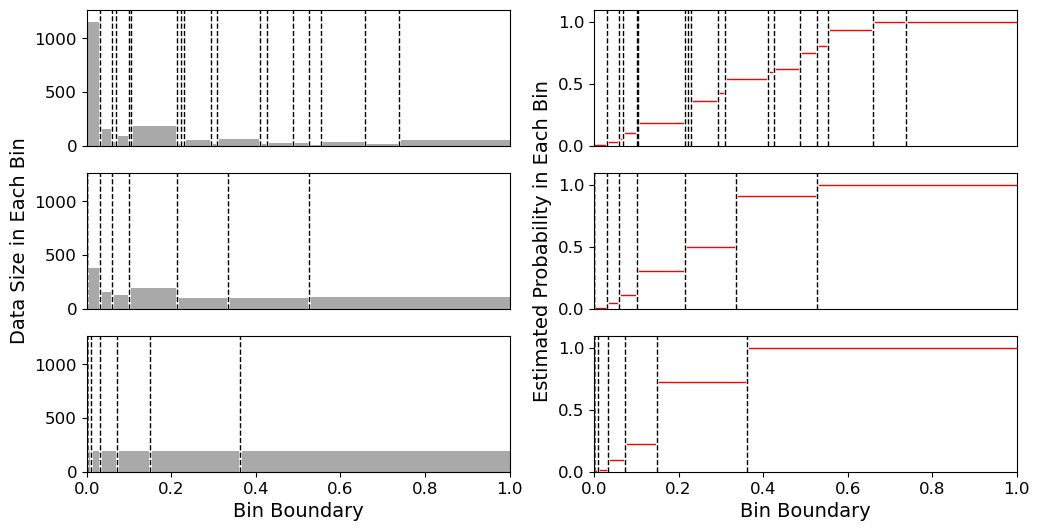

In [24]:
do_experiment("satimage", "RF")

Total-Variance PAVA              : 0.0509
Total-Variance PAVABC            : 0.0517
Total-Variance Quantile          : 0.0521
Average Within-Variance PAVA     : 0.0834
Average Within-Variance PAVABC   : 0.0627
Average Within-Variance Quantile : 0.0520


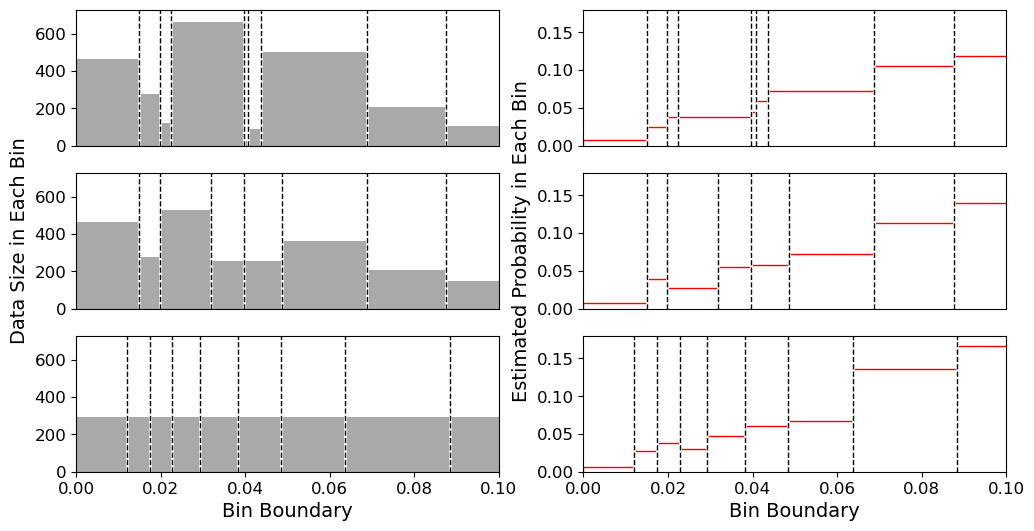

In [25]:
do_experiment("coil_2000", "RF", xlim1=0.10, ylim1=0.18)